In [7]:
# Import modules
# import pickle
import h5py as h5
# import os
# import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# import netCDF4 as nc
# import itertools
import datetime
import time
from scipy.io import loadmat

# import statsmodels.api as sm

In [95]:
# Set plot parameters (seaborn, matplotlib)
sb=True
if sb:
    sns.set()
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
#     sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid",{"xtick.top":True, "xtick.bottom":True,"ytick.left":True, "ytick.right":True})
# plt.style.use('seaborn-notebook')

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams.update({'figure.autolayout': True})
fontsz = 20
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams["axes.labelsize"] = 22
plt.rcParams['figure.figsize'] = [10, 8]

In [2]:
def decyeartodatetime(din):
    start = din
    year = int(start)
    rem = start - year
    base = datetime.datetime(year, 1, 1)
    result = base + datetime.timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
#     if result.hour>12:
#         result = result+dt.timedelta(days=1)
#     result2 = result.replace(hour=0, minute=0, second=0, microsecond=0)
    result2 = result.replace(minute=0, second=0, microsecond=0)
    return result2

# OLD STUFF
# ----------------------

In [3]:
#### CHANGE THE PATH TO POINT AT THESE FILES
fsmb = loadmat('relayerthinningpaper/SMB_MERRA_atpix.mat')
ftskin = loadmat('relayerthinningpaper/TEMP_MERRA_atpix.mat')
ftime = loadmat('relayerthinningpaper/TIME_MERRA-2_Mod.mat')

In [27]:
merra_time = ftime['time']
smb = fsmb['smb']
tskin = ftskin['temp']
dti = [decyeartodatetime(ii) for ii in merra_time.flatten()]
M_df = pd.DataFrame({'decdate':merra_time.flatten(),'smb':smb.flatten(),'tskin':tskin.flatten()},index=dti)
i2019 = np.where(M_df.index.year==2019)[0]
M_df.drop(M_df.iloc[i2019].index,inplace=True) #get rid of 2019 data

In [65]:
M_df['smb_pertime'] = M_df['smb']*5/365.25 # just checking that we get the same answer when we take the mean and sum

In [68]:
annual_df = M_df.resample('a').agg({'decdate':'mean','smb':'mean','tskin':'mean','smb_pertime':'sum'})

In [81]:
spinuptime = 600 # years you want to spin up for 
data_timestart = 1980
data_timeend = 2018
modeltimestart = data_timestart-spinuptime
modeltime = np.arange(modeltimestart,data_timeend+1)

In [82]:

smb_mean = annual_df.smb['1980':'2007'].mean()
smb_sd = annual_df.smb['1980':'2007'].std()
spin_smb = np.random.normal(smb_mean,smb_sd,spinuptime) #generate a random SMB for each year of the spin up
smb_full = np.concatenate((spin_smb,annual_df.smb.values))
smb_out = np.array((modeltime,smb_full))

tskin_mean = annual_df.tskin['1980':'2007'].mean()
tskin_sd = annual_df.tskin['1980':'2007'].std()
spin_tskin = np.random.normal(tskin_mean,tskin_sd,spinuptime) #generate a random SMB for each year of the spin up
tskin_full = np.concatenate((spin_tskin,annual_df.tskin.values))
tskin_out = np.array((modeltime,tskin_full))

np.savetxt('smb_out.csv',smb_out,delimiter=',',fmt='%1.4f')
np.savetxt('tskin_out.csv',tskin_out,delimiter=',',fmt='%1.4f')

# END OLD STUFF
# ----------------------

# CFM Results

In [92]:
# Import CFM results
st_results=h5.File('ASHL_results_st/CFMresults.hdf5','r') # strain results
dep_st = st_results['depth'][1:,1:]
den_st = st_results['density'][1:,1:]
age_st = st_results['age'][1:]
st_results.close()

ns_results=h5.File('ASHL_results_ns/CFMresults.hdf5','r') #no strain 
dep_ns = ns_results['depth'][1:,1:]
den_ns = ns_results['density'][1:,1:]
age_ns = ns_results['age'][1:]
ns_results.close()

In [101]:
# analytic HLA solution
import hl_analytic as hla #import hl_analytic module
h = np.arange(0,120.1,0.1) #depth vector for HLA
ageANs, rhoAN = hla.hl_analytic(350,h,243,0.24) # run HLA; age is in seconds
ageANy = ageANs/hla.S_PER_YEAR # age in years
# hST = h*((-1.0e-3+1)**ageANy)
SRT = 1.0e-3
hST = np.append(0,np.cumsum(((-1*SRT+1)**ageANy[:-1])*np.diff(h))) #strained depth profile

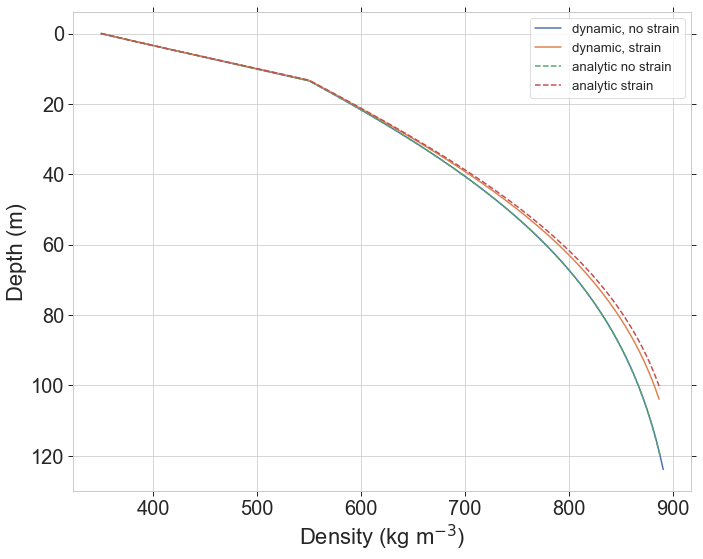

In [98]:
f1,a1 = plt.subplots(figsize=(10,8))
a1.plot(den_ns[-1,:],dep_ns[-1,:],label='dynamic, no strain')
a1.plot(den_st[-1,:],dep_st[-1,:],label='dynamic, strain')
a1.plot(rhoAN,h,label='analytic no strain',ls='--')
a1.plot(rhoAN,hST,label='analytic strain',ls='--')
a1.invert_yaxis()
a1.legend()
a1.set_ylabel('Depth (m)')
a1.set_xlabel(r'Density (kg m$^{-3}$)')
f1.savefig('Annika_analyticstrain.png')